In [1]:
import seaborn as sns
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from IPython.display import display, HTML

#import my modules
import acquire as a
import prepare as p

from sklearn.preprocessing import MinMaxScaler, RobustScaler

# Acquire

In [2]:
df = a.get_zillow()

In [3]:
df.head()

,parcelid,basementsqft,bathroomcnt,bedroomcnt,decktypeid,calculatedfinishedsquarefeet,fips,fireplacecnt,garagecarcnt,hashottuborspa,...,regionidcounty,regionidzip,typeconstructiondesc,unitcnt,structuretaxvaluedollarcnt,landtaxvaluedollarcnt,taxvaluedollarcnt,taxamount,logerror,transactiondate
0,14297519,NaN,3.5,4.0,NaN,3100.0,6059.0,NaN,2.0,NaN,...,1286.0,96978.0,NaN,NaN,485713.0,537569.0,1023282.0,11013.72,0.025595,2017-01-01
1,17052889,NaN,1.0,2.0,NaN,1465.0,6111.0,1.0,1.0,NaN,...,2061.0,97099.0,NaN,NaN,88000.0,376000.0,464000.0,5672.48,0.055619,2017-01-01
2,14186244,NaN,2.0,3.0,NaN,1243.0,6059.0,NaN,2.0,NaN,...,1286.0,97078.0,NaN,NaN,85289.0,479489.0,564778.0,6488.30,0.005383,2017-01-01
3,12177905,NaN,3.0,4.0,NaN,2376.0,6037.0,NaN,NaN,NaN,...,3101.0,96330.0,NaN,1.0,108918.0,36225.0,145143.0,1777.51,-0.103410,2017-01-01
4,10887214,NaN,3.0,3.0,NaN,1312.0,6037.0,NaN,NaN,NaN,...,3101.0,96451.0,NaN,1.0,73681.0,45726.0,119407.0,1533.89,0.006940,2017-01-01


In [4]:
df.shape

(77579, 36)

In [5]:
#getting the latest transactions 
df = df.sort_values(by ='transactiondate', ascending=True).drop_duplicates( subset = 'parcelid' ,keep= 'last')
  

In [6]:
df.shape

(77381, 36)

In [7]:
#this list has all types of single unit properties
single= ['Single Family Residential',' Mobile Home' , 'Townhouse ', 'Manufactured, Modular, Prefabricated Homes'  ]

In [8]:
#create a mask
single_mask = df['propertylandusedesc'].isin(single)

In [9]:
#if unitcnt == that's means is is a single property but if it is null we can compare with our list of single

In [10]:
#using that mask and also add  a condition
df_single = df[single_mask & ((df['unitcnt'] == 1) | (df['unitcnt'].isnull()))]
    

In [11]:
#this df contains all single unit homes of 2017 with the latest transaction
df_single.shape

(52350, 36)

In [12]:
a.summarize(df_single)

Dataframe shape: 
(52350, 36)
Dataframe head: 
   parcelid  basementsqft  bathroomcnt  bedroomcnt  decktypeid  \
0  14297519           NaN          3.5         4.0         NaN   
1  17052889           NaN          1.0         2.0         NaN   
2  14186244           NaN          2.0         3.0         NaN   

   calculatedfinishedsquarefeet    fips  fireplacecnt  garagecarcnt  \
0                        3100.0  6059.0           NaN           2.0   
1                        1465.0  6111.0           1.0           1.0   
2                        1243.0  6059.0           NaN           2.0   

   hashottuborspa  ...  regionidcounty  regionidzip  typeconstructiondesc  \
0             NaN  ...          1286.0      96978.0                   NaN   
1             NaN  ...          2061.0      97099.0                   NaN   
2             NaN  ...          1286.0      97078.0                   NaN   

   unitcnt  structuretaxvaluedollarcnt  landtaxvaluedollarcnt  \
0      NaN                   

Unique Values :  1
 
Basement    47
Name: storydesc, dtype: int64
**propertylandusetypeid**
Unique Values :  2
 
261.0    52292
275.0       58
Name: propertylandusetypeid, dtype: int64
**propertylandusedesc**
Unique Values :  2
 
Single Family Residential                     52292
Manufactured, Modular, Prefabricated Homes       58
Name: propertylandusedesc, dtype: int64
**typeconstructiontypeid**
Unique Values :  2
 
4.0     1
6.0    75
Name: typeconstructiontypeid, dtype: int64
**regionidcity**
Unique Values :  175
 
(3097.9339999999997, 7421.65]     2617
(7421.65, 11352.3]                1633
(11352.3, 15282.95]              15619
(15282.95, 19213.6]               2921
(19213.6, 23144.25]               1243
                                 ...  
(376902.75, 380833.4]                0
(380833.4, 384764.05]                0
(384764.05, 388694.7]                0
(388694.7, 392625.35]                0
(392625.35, 396556.0]              779
Name: regionidcity, Length: 100, dtype: int64


**takeaways**
- numberofstories there is one property with 6 stories , I would drop it!
- unitcnt is not needed any more. I would drop it
- there are a lot of nulls so in preparation step I will handle them

# Preparation

In [13]:
p.miss_dup_values(df_single)

Your selected dataframe has 36 columns.
There are 25 columns that have missing values.
  
** There are 0 duplicate rows that represents 0.0% of total Values**


,Missing Values,% of Total Values
basementsqft,52303,99.9
storydesc,52303,99.9
storytypeid,52303,99.9
architecturalstyledesc,52280,99.9
architecturalstyletypeid,52280,99.9
typeconstructiontypeid,52274,99.9
typeconstructiondesc,52274,99.9
decktypeid,51960,99.3
hashottuborspa,50836,97.1
fireplacecnt,45120,86.2


In [14]:
df_single.shape

(52350, 36)

In [15]:
# I will drop columns and rows with a lot of null values 
#here I will include unitcnt because the value is 1 for all the properties . as it is the next to 65.6% 
#I can include it in my function
df_single= p.handle_missing_values(df_single, prop_required_columns=0.75, prop_required_row=0.75)

In [16]:
df_single.shape

(52348, 20)

In [17]:
p.miss_dup_values(df_single)

Your selected dataframe has 20 columns.
There are 9 columns that have missing values.
  
** There are 0 duplicate rows that represents 0.0% of total Values**


,Missing Values,% of Total Values
regionidcity,1034,2.0
lotsizesquarefeet,364,0.7
yearbuilt,118,0.2
structuretaxvaluedollarcnt,87,0.2
calculatedfinishedsquarefeet,86,0.2
regionidzip,25,0.0
taxamount,4,0.0
landtaxvaluedollarcnt,1,0.0
taxvaluedollarcnt,1,0.0


In [18]:

#all these  columns represent a minimun amount so I can drop them 
df_single= p.drop_low_missing_values(df_single, per= 3 )

In [19]:
df_single.shape

(50819, 20)

In [20]:
p.miss_dup_values(df_single)

Your selected dataframe has 20 columns.
There are 0 columns that have missing values.
  
** There are 0 duplicate rows that represents 0.0% of total Values**


,Missing Values,% of Total Values


In [21]:
a.summarize(df_single)

Dataframe shape: 
(50819, 20)
Dataframe head: 
   parcelid  bathroomcnt  bedroomcnt  calculatedfinishedsquarefeet    fips  \
0  14297519          3.5         4.0                        3100.0  6059.0   
1  17052889          1.0         2.0                        1465.0  6111.0   
2  14186244          2.0         3.0                        1243.0  6059.0   

     latitude    longitude  lotsizesquarefeet  yearbuilt  \
0  33634931.0 -117869207.0             4506.0     1998.0   
1  34449266.0 -119281531.0            12647.0     1967.0   
2  33886168.0 -117823170.0             8432.0     1962.0   

   propertylandusetypeid        propertylandusedesc  regionidcity  \
0                  261.0  Single Family Residential       53571.0   
1                  261.0  Single Family Residential       13091.0   
2                  261.0  Single Family Residential       21412.0   

   regionidcounty  regionidzip  structuretaxvaluedollarcnt  \
0          1286.0      96978.0                    485713.0  

Name: regionidcity, Length: 100, dtype: int64
**regionidcounty**
Unique Values :  3
 
1286.0    13685
2061.0     4378
3101.0    32756
Name: regionidcounty, dtype: int64
**regionidzip**
Unique Values :  378
 
(95678.306, 99018.93]     50808
(99018.93, 102055.86]         0
(102055.86, 105092.79]        0
(105092.79, 108129.72]        0
(108129.72, 111166.65]        0
                          ...  
(384490.35, 387527.28]        0
(387527.28, 390564.21]        0
(390564.21, 393601.14]        0
(393601.14, 396638.07]        0
(396638.07, 399675.0]        11
Name: regionidzip, Length: 100, dtype: int64
**structuretaxvaluedollarcnt**
Unique Values :  36381
 
**landtaxvaluedollarcnt**
Unique Values :  35969
 
**taxvaluedollarcnt**
Unique Values :  37987
 
**taxamount**
Unique Values :  49402
 
**logerror**
Unique Values :  50576
 
**transactiondate**
Unique Values :  257
 


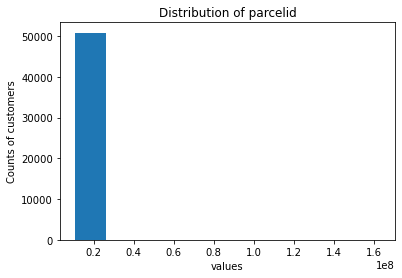

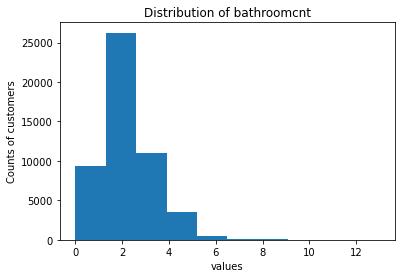

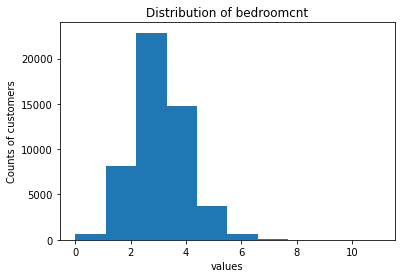

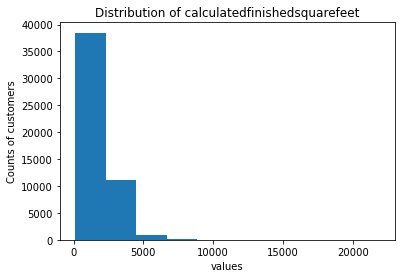

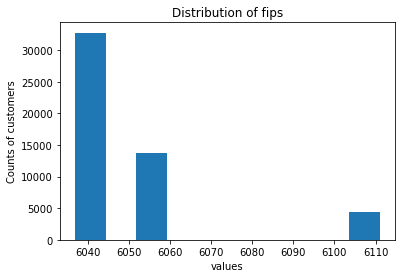

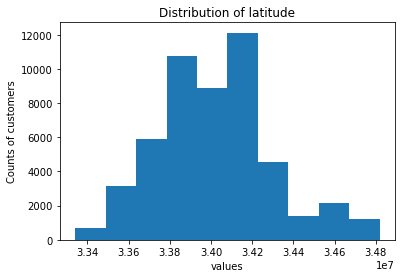

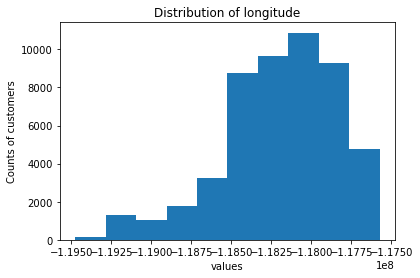

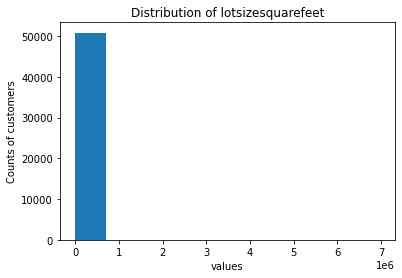

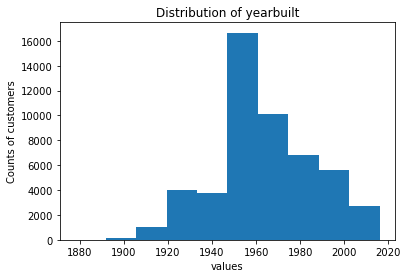

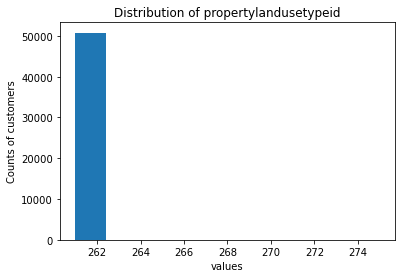

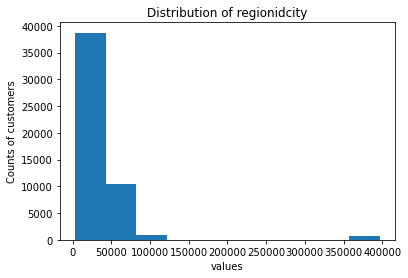

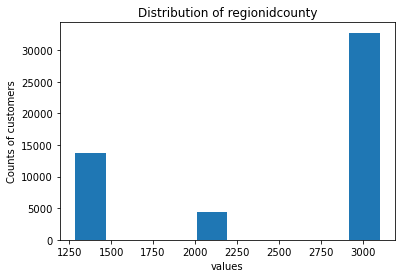

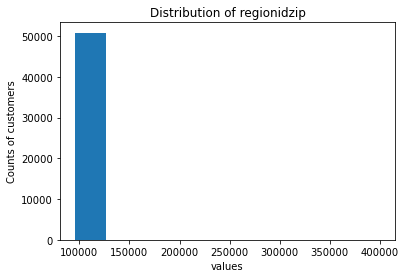

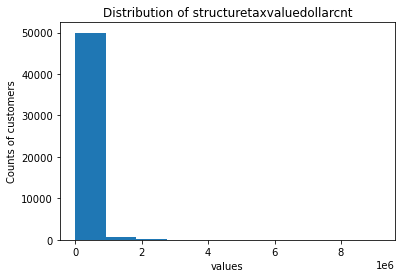

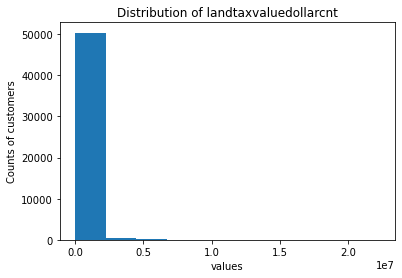

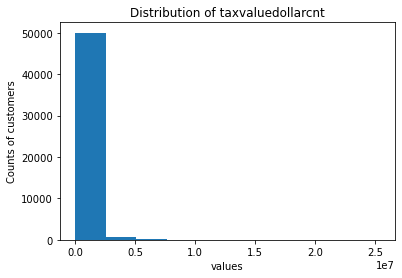

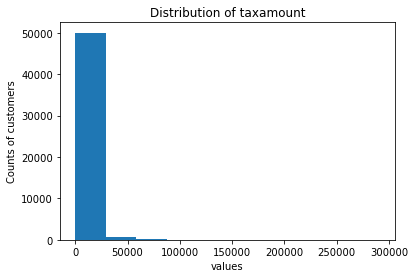

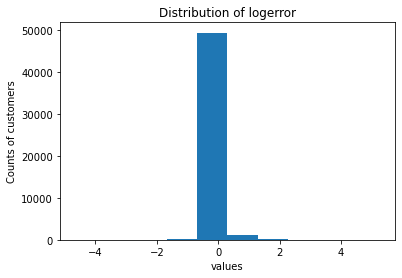

In [22]:
p.distribution(df_single)

### get county names and create dummy variables with those

In [23]:
# create dummy vars of fips id
county_df = pd.get_dummies(df_single.fips)

In [24]:
county_df.head()

,6037.0,6059.0,6111.0
0,0,1,0
1,0,0,1
2,0,1,0
3,1,0,0
6,1,0,0


- county # 6037 -----> Los Angeles
- county # 6059 -----> Orange
- county # 6111 -----> Ventura

In [25]:
df_single = p.get_counties(df_single)

In [26]:
# print("LA County Verified: ", df_single[df_single.fips==6037]['fips'].count() == df_single.los_angeles.sum())
# print("Orange County Verified: ", df_single[df_single.fips==6059]['fips'].count() == df_single.orange.sum())
# print("Ventura County Verified: ", df_single[df_single.fips==6111]['fips'].count() == df_single.ventura.sum())

In [27]:
#now in my function I can drop fips

###  Compute new features out of existing features in order to reduce noise, capture signals, and reduce collinearity, or dependence between independent variables.

**- age**

In [28]:
df_single['age'] = 2017 - df.yearbuilt

In [29]:
df_single.head()

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,latitude,longitude,lotsizesquarefeet,yearbuilt,propertylandusetypeid,propertylandusedesc,...,structuretaxvaluedollarcnt,landtaxvaluedollarcnt,taxvaluedollarcnt,taxamount,logerror,transactiondate,los_angeles,orange,ventura,age
0,14297519,3.5,4.0,3100.0,33634931.0,-117869207.0,4506.0,1998.0,261.0,Single Family Residential,...,485713.0,537569.0,1023282.0,11013.72,0.025595,2017-01-01,0,1,0,19.0
1,17052889,1.0,2.0,1465.0,34449266.0,-119281531.0,12647.0,1967.0,261.0,Single Family Residential,...,88000.0,376000.0,464000.0,5672.48,0.055619,2017-01-01,0,0,1,50.0
2,14186244,2.0,3.0,1243.0,33886168.0,-117823170.0,8432.0,1962.0,261.0,Single Family Residential,...,85289.0,479489.0,564778.0,6488.30,0.005383,2017-01-01,0,1,0,55.0
3,12177905,3.0,4.0,2376.0,34245180.0,-118240722.0,13038.0,1970.0,261.0,Single Family Residential,...,108918.0,36225.0,145143.0,1777.51,-0.103410,2017-01-01,1,0,0,47.0
6,12095076,3.0,4.0,2962.0,34145202.0,-118179824.0,63000.0,1950.0,261.0,Single Family Residential,...,276684.0,496619.0,773303.0,9516.26,-0.001011,2017-01-01,1,0,0,67.0


In [30]:
df_single[['age']].describe()

,age
count,50819.000000
mean,53.981523
std,22.812845
min,1.000000
25%,39.000000
50%,57.000000
75%,67.000000
max,139.000000


In [31]:
# I can drop yearbuilt

**- taxrate**


In [32]:
df_single['taxrate'] = df_single.taxamount/df_single.taxvaluedollarcnt*100

In [33]:
df_single[['taxrate']].describe()

,taxrate
count,50819.000000
mean,1.332409
std,0.563718
min,0.009372
25%,1.163323
50%,1.231985
75%,1.365681
max,49.364739


In [34]:
# I will drop taxamount and taxvaluedollarcnt

**- transactiondate**


In [35]:
df_single[['transactiondate']].head()

,transactiondate
0,2017-01-01
1,2017-01-01
2,2017-01-01
3,2017-01-01
6,2017-01-01


In [36]:
#I decided to convert transaction date to int so in the future can make groups

In [37]:
df_single['transactiondate']=(df_single['transactiondate'].str.replace(' ','').str.replace('-',''))

In [38]:
df_single['transactiondate'] = df_single['transactiondate'].astype('int')

In [39]:
#df_single[(df_single.transactiondate >= 20170101) &  (df_single.transactiondate < 20170501)]

In [40]:
df_single.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50819 entries, 0 to 77578
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      50819 non-null  int64  
 1   bathroomcnt                   50819 non-null  float64
 2   bedroomcnt                    50819 non-null  float64
 3   calculatedfinishedsquarefeet  50819 non-null  float64
 4   latitude                      50819 non-null  float64
 5   longitude                     50819 non-null  float64
 6   lotsizesquarefeet             50819 non-null  float64
 7   yearbuilt                     50819 non-null  float64
 8   propertylandusetypeid         50819 non-null  float64
 9   propertylandusedesc           50819 non-null  object 
 10  regionidcity                  50819 non-null  float64
 11  regionidzip                   50819 non-null  float64
 12  structuretaxvaluedollarcnt    50819 non-null  float64
 13  l

In [41]:
df_single['lotsize_acres'] = df_single.lotsizesquarefeet/43560
df_single = df_single.drop(columns = ['yearbuilt', 'taxamount', 'taxvaluedollarcnt', 'lotsizesquarefeet'  ])

In [42]:
def create_features (df) :
    '''
    takes in a df and create age , taxrate, lotsize_acres columns and convert transactiondate to int
    drops 'yearbuilt', 'taxamount', 'taxvaluedollarcnt', lotsizesquarefeet columns
    '''
    #create a new colum with age
    df['age'] = 2017 - df.yearbuilt
    
    #taxrate
    df['taxrate'] = df.taxamount/df.taxvaluedollarcnt*100
    
    #transactiondate
    df['transactiondate']=(df['transactiondate'].str.replace(' ','').str.replace('-',''))
    df['transactiondate'] = df['transactiondate'].astype('int')
    
     # create acres variable
    df['lotsize_acres'] = df.lotsizesquarefeet/43560
    
    #drop columns
    df = df.drop(columns = ['yearbuilt', 'taxamount', 'taxvaluedollarcnt', 'lotsizesquarefeet'  ])
    
    return df

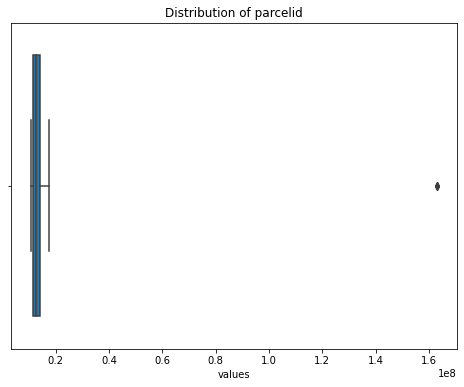

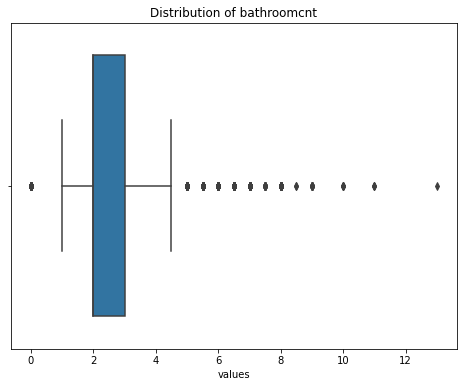

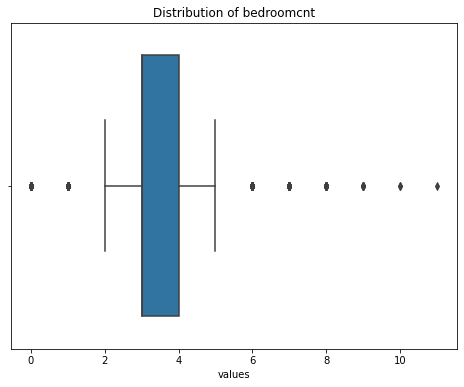

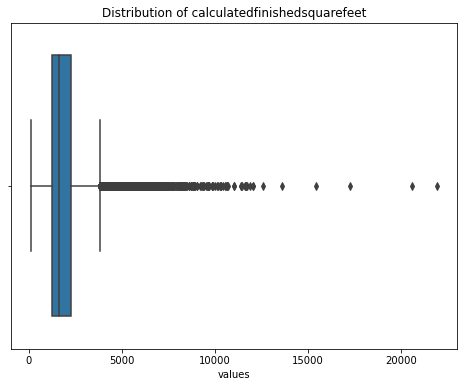

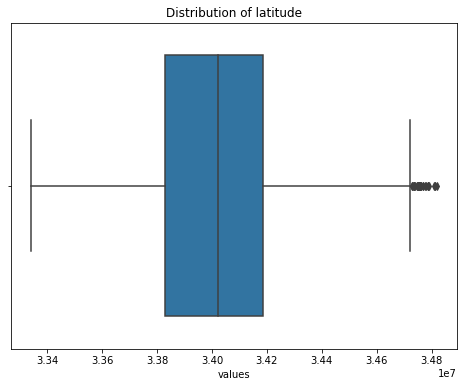

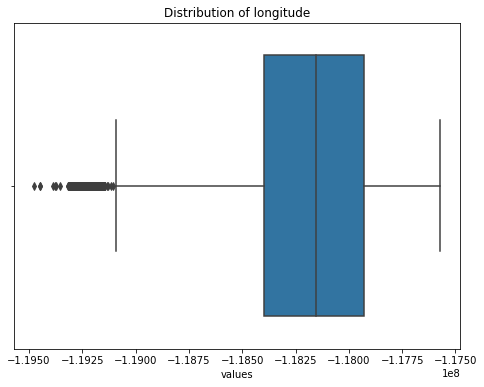

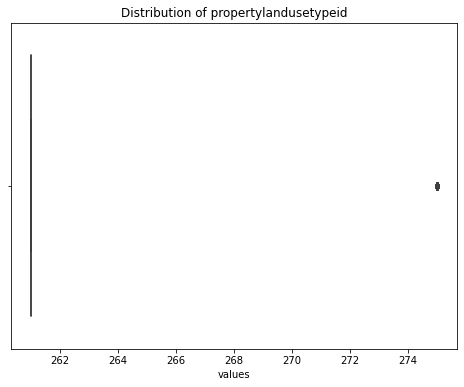

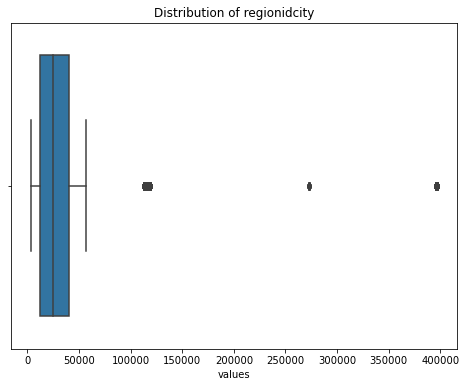

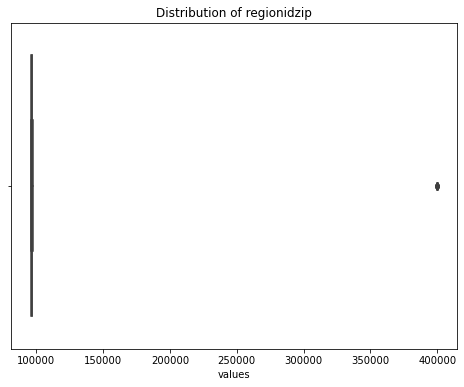

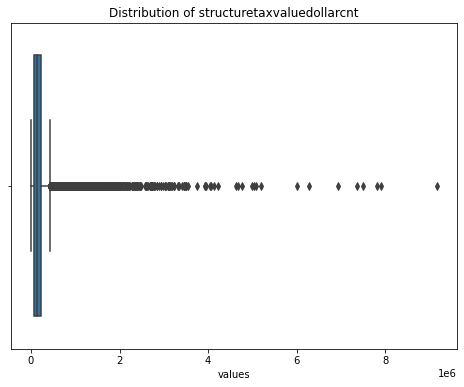

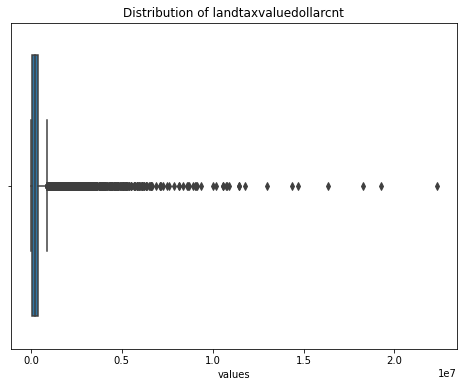

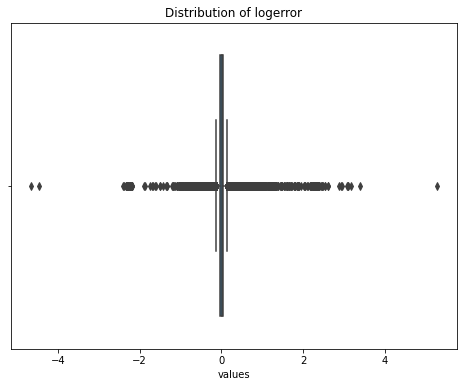

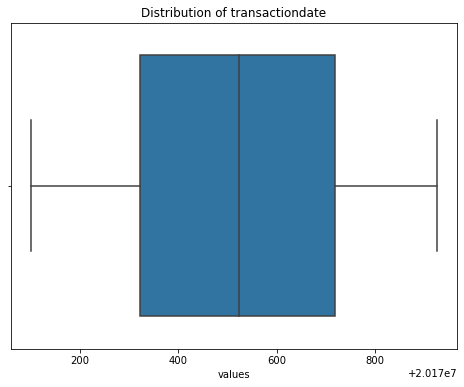

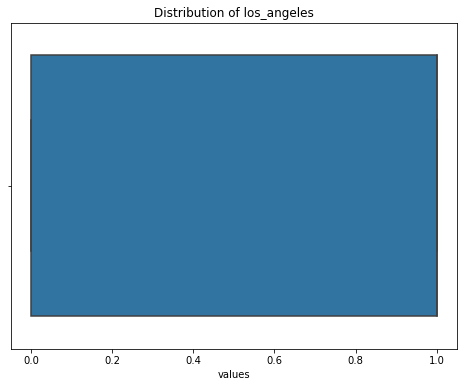

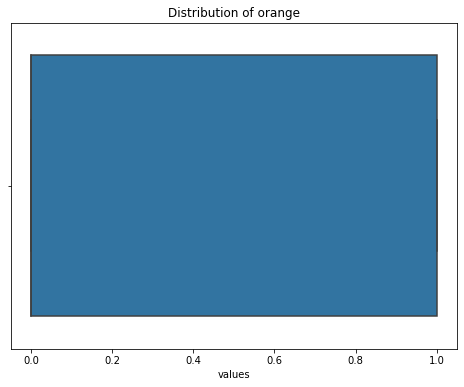

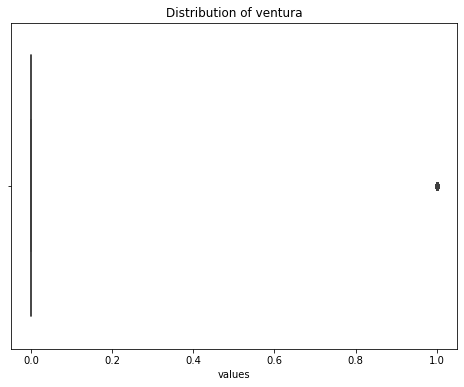

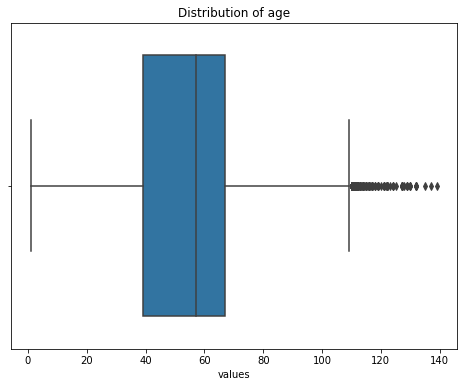

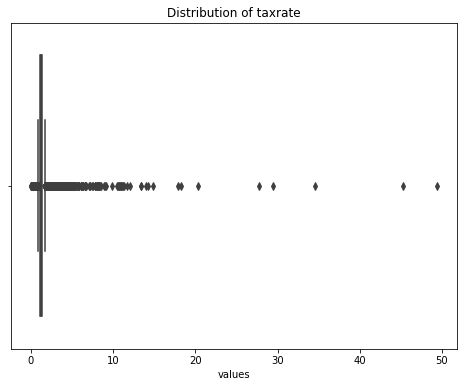

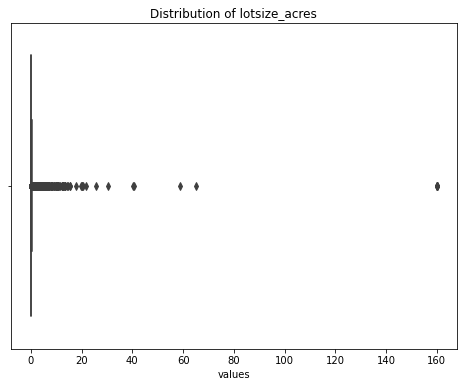

In [43]:
p.distribution_boxplot(df_single)

In [44]:
df_single.columns

Index(['parcelid', 'bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet',
       'latitude', 'longitude', 'propertylandusetypeid', 'propertylandusedesc',
       'regionidcity', 'regionidzip', 'structuretaxvaluedollarcnt',
       'landtaxvaluedollarcnt', 'logerror', 'transactiondate', 'los_angeles',
       'orange', 'ventura', 'age', 'taxrate', 'lotsize_acres'],
      dtype='object')

In [ ]:
# I will handle outliers for : 'bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'regionidzip', 
#'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxrate', 'lotsize_acres', 'age'

In [45]:
col = ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'regionidzip', 'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxrate', 'lotsize_acres', 'age']

In [46]:
df_final= p.remove_outliers(df_single, col)

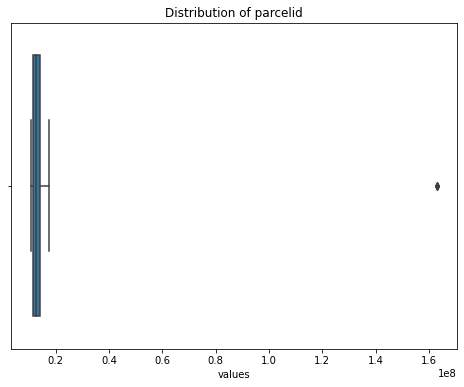

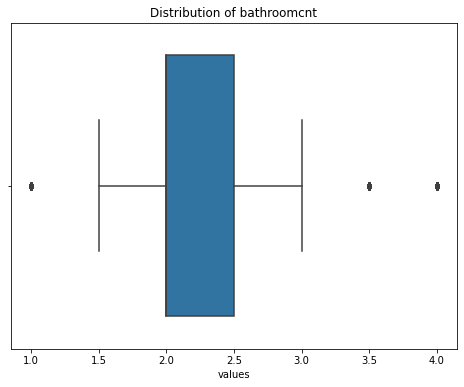

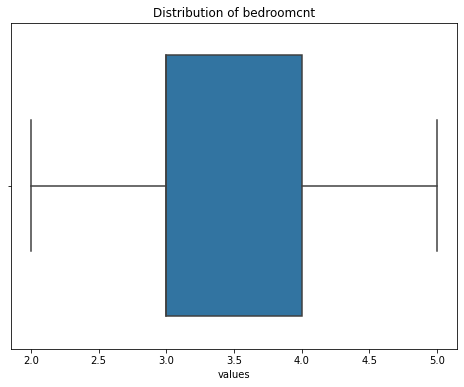

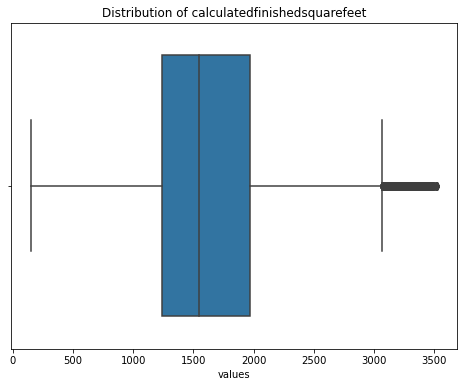

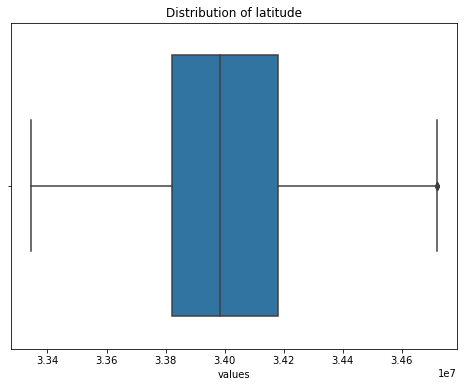

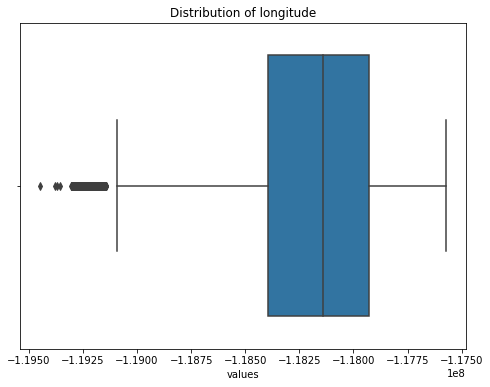

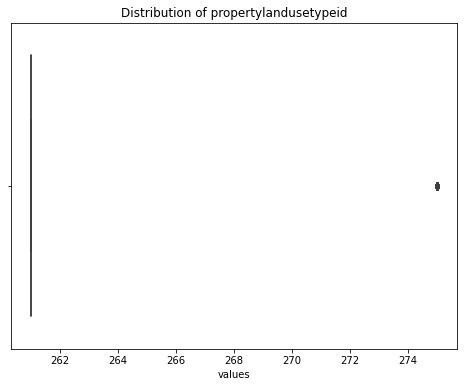

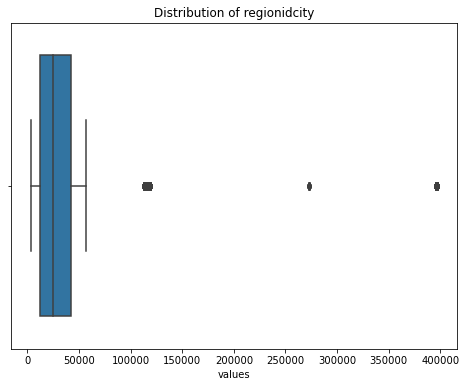

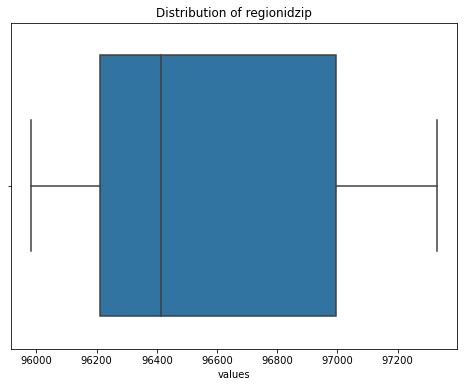

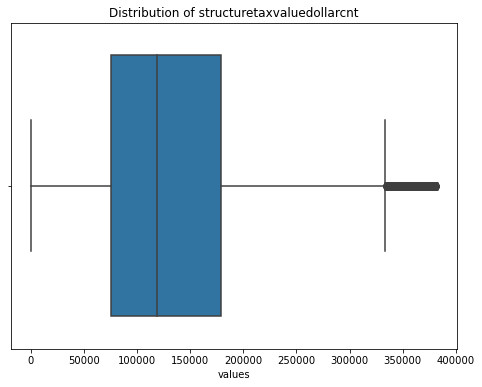

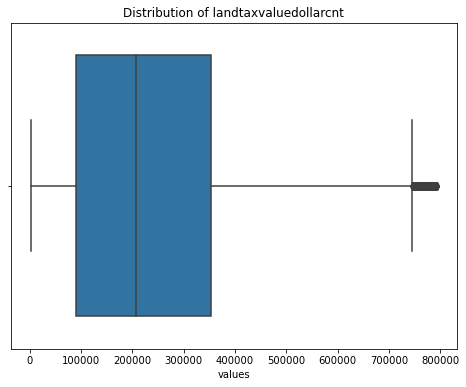

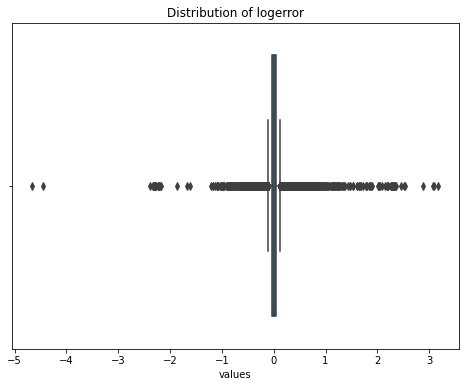

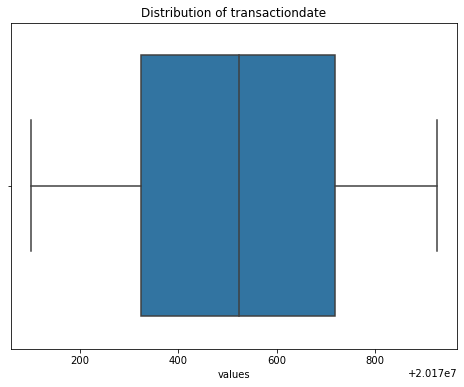

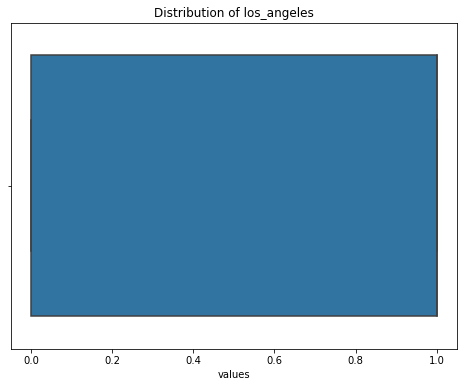

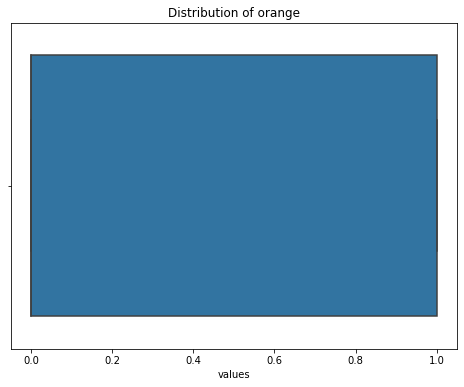

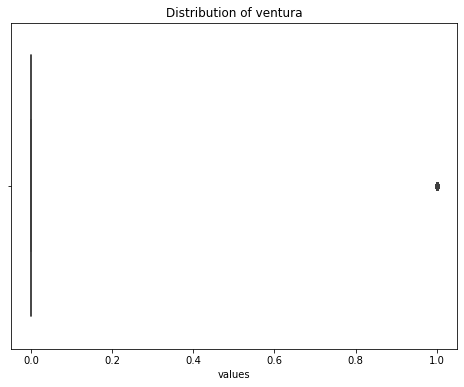

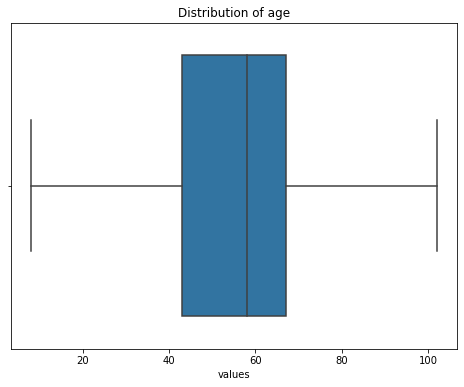

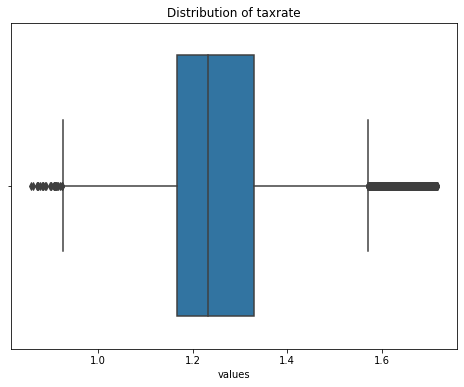

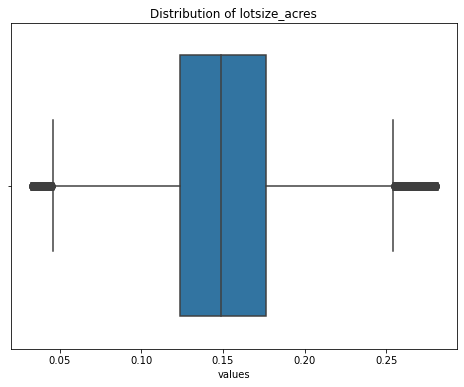

In [47]:
p.distribution_boxplot(df_final)

In [50]:
df_final.shape, df_single.shape

((34126, 20), (50819, 20))

In [52]:
df_final['regionidcity'].value_counts()

12447.0    7549
46298.0    1235
16764.0     917
5534.0      717
25218.0     705
           ... 
14906.0       1
53162.0       1
36078.0       1
21395.0       1
13311.0       1
Name: regionidcity, Length: 167, dtype: int64

In [53]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34126 entries, 2 to 77578
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      34126 non-null  int64  
 1   bathroomcnt                   34126 non-null  float64
 2   bedroomcnt                    34126 non-null  float64
 3   calculatedfinishedsquarefeet  34126 non-null  float64
 4   latitude                      34126 non-null  float64
 5   longitude                     34126 non-null  float64
 6   propertylandusetypeid         34126 non-null  float64
 7   propertylandusedesc           34126 non-null  object 
 8   regionidcity                  34126 non-null  float64
 9   regionidzip                   34126 non-null  float64
 10  structuretaxvaluedollarcnt    34126 non-null  float64
 11  landtaxvaluedollarcnt         34126 non-null  float64
 12  logerror                      34126 non-null  float64
 13  t

In [ ]:
# here i can drop
# propertylandusedesc 